# ResNet-50 with Neutrino Dataset

### Importing essential libraries
this will be cleaned, some are inessential

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
import sklearn
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

I check here if cuda gpu is available

In [3]:
torch.cuda.is_available()

True

## Model, Train, and Test

I define here the model (ResNet-50) and the train and test function. The model takes as input images channel first with 3 channels. The test definition is week and it could lead to a memory leak. 

In [4]:
#pred_list and target_list are two lists of cuda tensors containing respectively the predictions and the 
#target values. Each tensor will be test_batch_size in lenght. Each list will contain 
#(amount of test samples/test_batch_size)*epochs samples. E.g. with 10k test samples, test_batch_size = 1k and
#4 epochs you'll get a list of 40 elements, each element 1k. Further down these lists will be converted in arrays.

pred_list = []
target_list = []
accuracy = []
loss = []
epochs = 1
test_batch = 1
    
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(Bottleneck, [3,4,6,3], num_classes=3)
        self.conv1 = torch.nn.Conv2d(3, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)
######if you then use nll_loss you have to use log_sotmax        
    def forward(self, x):
        return F.log_softmax(
            super(MnistResNet, self).forward(x), dim=-1)

        



def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            volatile=True
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            pred_list.append(pred)
            target_list.append(target)
            
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    accuracy.append(100. * correct / len(test_loader.dataset))
    loss.append(test_loss)

## Dataset

I implemented here a simple dataset. At the moment, it takes a tensor as data and numpy array as target. Moreover, it only takes one file. This is something that I will need to change in the future since we have several files.

In [5]:
#implementing DataSet

class NeutrinoDataset(Dataset):
    """The training table dataset.
    """
    def __init__(self, x_tensor, y_path):
        #x_filenames = glob(x_path + '*.png') # Get the filenames of all training images
        
        #self.x_data = [torch.from_numpy(misc.imread(filename)) for filename in x_filenames] # Load the images into torch tensors
        #self.y_data = target_label_list # Class labels
        self.x_data = x_tensor
        self.y_data = torch.from_numpy(np.load(y_path))
        self.len = len(self.x_data)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__(self):
        return self.len

## Importing files and preparing the dataset

In this part I import the train and test files, I normalize them and I reshape them to be channel first. This part could also lead to potential memory leaks. It would be nice to convert and normalise the numpy array in one go, but at the moment I can't.

In [6]:
x_train_temp = np.load('/home/stefano/neutrino/data/final_array_x/x_train_numu_500_0.npy')
x_test_temp = np.load('/home/stefano/neutrino/data/final_array_x/x_train_numu_500_1.npy')
y_test = np.load('/home/stefano/neutrino/data/final_array_y/y_train_numu_500_event_0.npy')
y_test = np.load('/home/stefano/neutrino/data/final_array_y/y_train_numu_500_event_1.npy')
    
y_train_path = '/home/stefano/neutrino/data/final_array_y/y_train_numu_500_event_0.npy'  
y_test_path = '/home/stefano/neutrino/data/final_array_y/y_train_numu_500_event_1.npy'



#normalise the data
old_min = np.min(x_train_temp)
old_max = np.max(x_train_temp)
print("Before:", old_min, old_max)
x_train = x_train_temp.astype('float32')
x_test = x_test_temp.astype('float32')
x_train /=255
x_test /= 255
new_min = np.min(x_train)
new_max = np.max(x_train)
print("After:", new_min, new_max)

print("Test Data Shape after conversion to float")
    
    #read the dimensions from one example in the trainig set
img_rows, img_cols = x_train[0].shape[0], x_train[0].shape[1]
print(x_train[0].shape[0])
print(x_train[0].shape[1])

#read the dimensions from one example in the trainig set
img_rows, img_cols = x_train[0].shape[0], x_train[0].shape[1]

#Different NN libraries (e.g., TF) use different ordering of dimensions
#Here we set the "input shape" so that later the NN knows what shape to expect
x_train_reshaped = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
x_test_reshaped = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
input_shape = (3, img_rows, img_cols)

print("input_shape",input_shape)
print("x_train[0].shape[0]", x_train_reshaped[0].shape[0])
print("x_train[0].shape[1]", x_train_reshaped[0].shape[1])
print("x_train[0].shape[2]", x_train_reshaped[0].shape[2])

x_train_temp = torch.from_numpy(x_train_reshaped).float()
x_test_temp = torch.from_numpy(x_test_reshaped).float()

dataset_test = NeutrinoDataset(x_test_temp, y_test_path)

Before: 0 254
After: 0.0 0.99607843
Test Data Shape after conversion to float
200
200
input_shape (3, 200, 200)
x_train[0].shape[0] 3
x_train[0].shape[1] 200
x_train[0].shape[2] 200


## Definition of main function

I define here the dataset and the main function. This seems to be the stronger part of the code.

In [7]:
import easydict
def main():
    args = easydict.EasyDict({
        "batch_size": 1,#it was 64
        "test_batch_size": 500,
        "epochs": epochs,
        "lr": 1.0,
        "gamma": 0.7,
        "no_cuda": False,
        "seed": 1,
        "log_interval":10,
        "save_model": False
    })
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
    #device = torch.device("cpu")
    
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    

    
    transform_train=transforms.Compose([ToTensor(),transforms.Normalize((0.011209016666666667,), (0.36950463408735745,))])
    transform_test=transforms.Compose([ToTensor(),transforms.Normalize((0.0171563,), (0.5148277654099112,))]) 
    
   # x_train_tensor = transform_train(x_train)
    #x_test_tensor = transform_test(x_test)
    
    
    #x_train_tensor = transforms.Normalize((0.011209016666666667,), (0.36950463408735745,), x_train_temp)
    #x_test_tensor = transforms.Normalize((0.0171563,), (0.5148277654099112,), x_test_temp)
    
    dataset_train = NeutrinoDataset(x_train_temp, y_train_path)
    dataset_test = NeutrinoDataset(x_test_temp, y_test_path)
    
    train_loader = torch.utils.data.DataLoader(dataset=dataset_train,
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test,
        batch_size=args.test_batch_size, shuffle=False, **kwargs)

    model = MnistResNet().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


### Plotting your Train and Test Dataset
It is important to always check your dataset. With the following lines images from your train and test dataset and randomly selected and plotted.

In this part I calcolate mean and std of the pics in case I find a way to use tensor.normalise. Skip this part when run the code.

In [8]:
use_cuda =  torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
    
%matplotlib inline 

x_train = torch.from_numpy(np.load('/home/stefano/neutrino/data/final_array_x/x_train_numu_500_0.npy')).float().to(device)
x_test = torch.from_numpy(np.load('/home/stefano/neutrino/data/final_array_x/x_train_numu_500_1.npy')).float().to(device)
y_train = torch.from_numpy(np.load('/home/stefano/neutrino/data/final_array_y/y_train_numu_500_event_0.npy')).float().to(device)
y_test = torch.from_numpy(np.load('/home/stefano/neutrino/data/final_array_y/y_train_numu_500_event_1.npy')).float().to(device)
print(x_train.shape)
#print(dataset1)
#dataset1 = torch.from_numpy(train).float().to(device)
#dataset2 = torch.from_numpy(test).float().to(device)
#dataset1 = ('../data/final_array_x/x_train_numu_500_0.npy',transforms.Compose([ 
                           #transforms.ToTensor()
                      #]))
#dataset2 = ('../data/final_array_x/x_train_numu_500_1.npy',transforms.Compose([ 
                          # transforms.ToTensor()
                       #]))
###this part is to calculate mean and std of the dataset resized
train_array = np.load('/home/stefano/neutrino/data/final_array_x/x_train_numu_500_0.npy')
test_array = np.load('/home/stefano/neutrino/data/final_array_x/x_train_numu_500_1.npy')
#for y in range (0,500):
#    z, _ = dataset1[y]
#    train_array.append(z.numpy()[0])
    
#for i in range (0,500):
#    x, _ = dataset2[i]
#    test_array.append(x.numpy()[0])

#for i in test_array : 
#    train_array.append(i)
    
#total_array=np.array(train_array)

print(test_array.mean())
print(test_array.std())
print(train_array.mean())
print(train_array.std())

#test mean with size 200x200 is 0.0171563
#test std with size 200x200 is 0.5148277654099112
#train mean with size 200x200 is 0.011209016666666667
#train std with size 200x200 is 0.36950463408735745
###############################


torch.Size([500, 200, 200, 3])
0.0171563
0.5148277654099112
0.011209016666666667
0.36950463408735745


## Visualisation

The following two cells contain a cool tool to visualise train and test dataset. Useful.

torch.Size([500, 200, 200, 3])
200
200
3
tensor(0., device='cuda:0')
now showing image  335


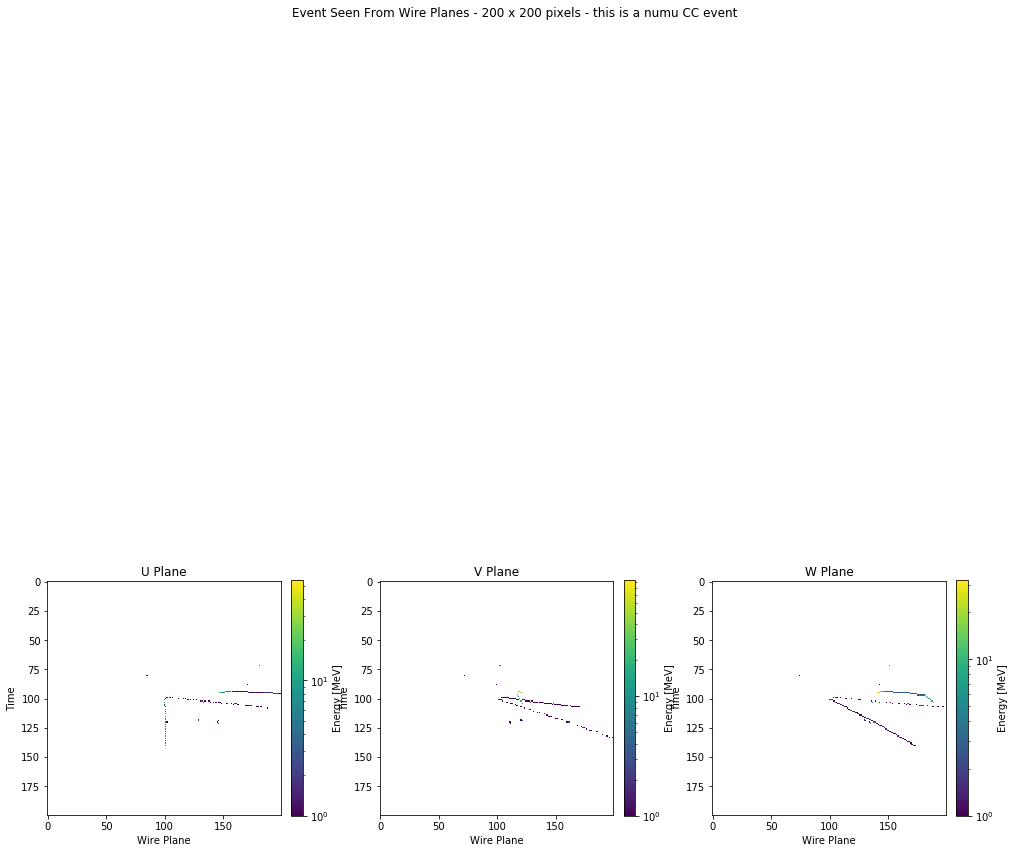

In [9]:
import numpy as np
import zlib
import matplotlib
import matplotlib.pyplot as plt
import zlib
import numpy as np
import os

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

figsize = [14, 20]
starting_number = torch.IntTensor.item(torch.LongTensor(1).random_(0, 500-1))#-(nrows*ncols)))
#number_pics = dataset1.shape[0]
print(x_train.shape)
#print('number pics is ', number_pics)
print(x_train.shape[1])
print(x_train.shape[2])
print(x_train.shape[3])

print(x_train[1,1,1,1])

x_train_cpu=x_train.cpu()
y_train_cpu=y_train.cpu()

print("now showing image ",(starting_number))

####this part is for the true value
#0 is for NC events
#1 is for numu CC events
#2 is for nue CC events
truth=y_train_cpu[starting_number]
if truth==0:
    truth_stg="NC"
elif truth==1:
    truth_stg="numu CC"
elif truth==2:
    truth_stg="nue CC"

a = x_train_cpu[(starting_number),:,:,0]

b = x_train_cpu[(starting_number),:,:,1]

c = x_train_cpu[(starting_number),:,:,2]


f, axarr = plt.subplots(1,3,figsize=figsize)#, constrained_layout=True)
f.suptitle('Event Seen From Wire Planes - 200 x 200 pixels - this is a '+truth_stg+' event')
im=axarr[0].imshow(a, norm=matplotlib.colors.LogNorm())
im2=axarr[1].imshow(b, norm=matplotlib.colors.LogNorm())
im3=axarr[2].imshow(c, norm=matplotlib.colors.LogNorm())
axarr[0].set_title('U Plane')
axarr[1].set_title('V Plane')
axarr[2].set_title('W Plane')
bar1=f.colorbar(im,ax=axarr[0],fraction=0.046,pad=0.04)
bar2=f.colorbar(im2,ax=axarr[1],fraction=0.046,pad=0.04)
bar3=f.colorbar(im3,ax=axarr[2],fraction=0.046,pad=0.04)
bar1.set_label('Energy [MeV]')
bar2.set_label('Energy [MeV]')
bar3.set_label('Energy [MeV]')
f.tight_layout() #this is to add more space between plots
for ax in axarr.flat:
    ax.set(xlabel='Wire Plane', ylabel='Time')

plt.show()
plt.close()


torch.Size([500, 200, 200, 3])
200
200
3
tensor(0., device='cuda:0')
now showing image  212


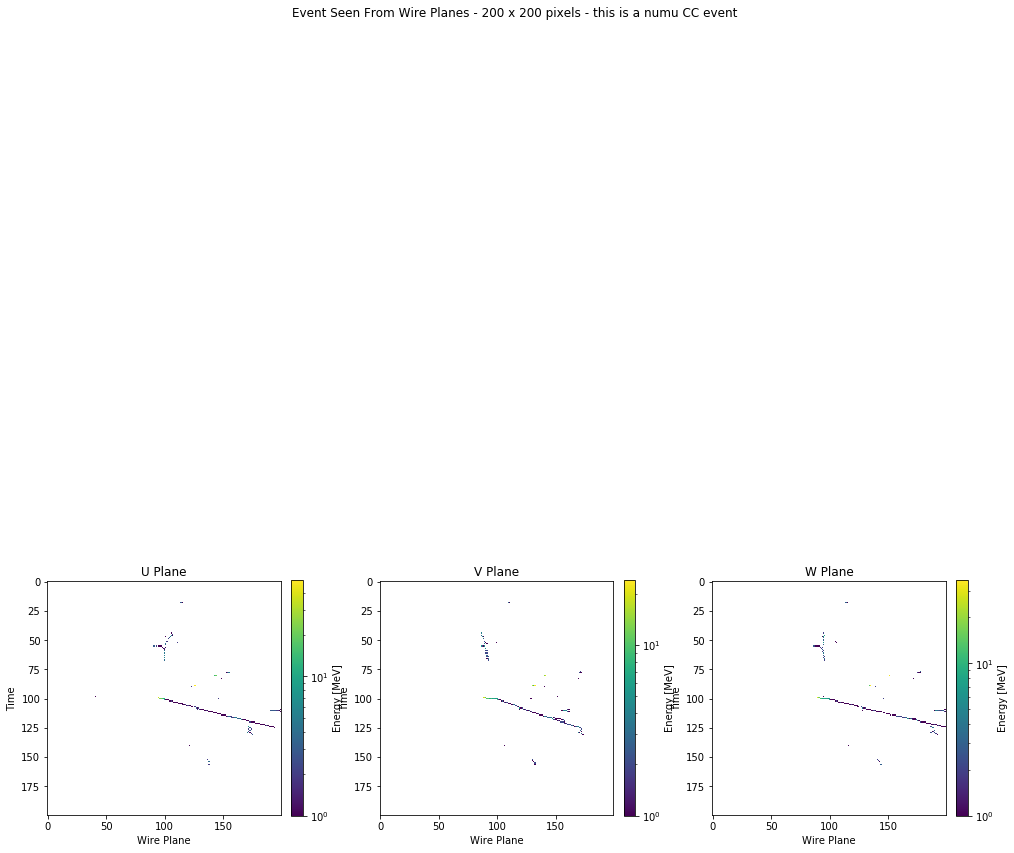

In [10]:
figsize = [14, 20]
starting_number = torch.IntTensor.item(torch.LongTensor(1).random_(0, 500-1))#-(nrows*ncols)))
#number_pics = dataset1.shape[0]
print(x_test.shape)
#print('number pics is ', number_pics)
print(x_test.shape[1])
print(x_test.shape[2])
print(x_test.shape[3])

print(x_test[1,1,1,1])

x_test_cpu=x_test.cpu()
y_test_cpu=y_test.cpu()

print("now showing image ",(starting_number))

####this part is for the true value
#0 is for NC events
#1 is for numu CC events
#2 is for nue CC events
truth=y_test_cpu[starting_number]
if truth==0:
    truth_stg="NC"
elif truth==1:
    truth_stg="numu CC"
elif truth==2:
    truth_stg="nue CC"

a = x_test_cpu[(starting_number),:,:,0]

b = x_test_cpu[(starting_number),:,:,1]

c = x_test_cpu[(starting_number),:,:,2]


f, axarr = plt.subplots(1,3,figsize=figsize)#, constrained_layout=True)
f.suptitle('Event Seen From Wire Planes - 200 x 200 pixels - this is a '+truth_stg+' event')
im=axarr[0].imshow(a, norm=matplotlib.colors.LogNorm())
im2=axarr[1].imshow(b, norm=matplotlib.colors.LogNorm())
im3=axarr[2].imshow(c, norm=matplotlib.colors.LogNorm())
axarr[0].set_title('U Plane')
axarr[1].set_title('V Plane')
axarr[2].set_title('W Plane')
bar1=f.colorbar(im,ax=axarr[0],fraction=0.046,pad=0.04)
bar2=f.colorbar(im2,ax=axarr[1],fraction=0.046,pad=0.04)
bar3=f.colorbar(im3,ax=axarr[2],fraction=0.046,pad=0.04)
bar1.set_label('Energy [MeV]')
bar2.set_label('Energy [MeV]')
bar3.set_label('Energy [MeV]')
f.tight_layout() #this is to add more space between plots
for ax in axarr.flat:
    ax.set(xlabel='Wire Plane', ylabel='Time')

plt.show()
plt.close()


Next cell could maybe help to clean some memory?

In [11]:
torch.cuda.empty_cache()

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

## Main Run

When GPU is used, it runs out of memory durign testing phase...

In [ ]:
start.record()
main()
end.record()

In [ ]:
print(start.elapsed_time(end))

In [ ]:
#non resnet:
# with gpu is was 129028.3828125 ms, that is ~130 s for 14 epochs - final test set 
# Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99%)
# with cpu is was 1085891.5 ms, that is ~1085 s ~ 18 m for 14 epochs - final test set loss 0.0295 
#accuracy 9911/10000 (99%)

#resnet50
# with gpu is was 1124874.75 ms, that is ~1125 s ~ 19 m for 14 epochs - final test set batch size 64
# Test set: Average loss: -0.8874, Accuracy: 8875/10000 (89%)
#resnet50
# with gpu is was 978600.0625 ms, that is ~978 s ~ 16 m for 14 epochs - final test set batch size 128
# Test set: Average loss: -0.9861, Accuracy: 9860/10000 (99%)
#resnet50 size 32x32
# with gpu is was 1012531.75 ms, that is ~1012 s ~ 17 m for 14 epochs - final test set batch size 128
# Test set: Average loss: -0.8869, Accuracy: 8869/10000 (89%)

#resnet50 size 32x32 log_softmax (dim=1) and nll_loss (10-02-2020)
# with gpu is was 996138.8125 ms, that is ~996 s ~ 17 m for 14 epochs - final test set batch size 128
# Test set: Average loss: 0.0236, Accuracy: 9942/10000 (99%)

#resnet50 size 32x32 log_softmax (dim=-1) and nll_loss (10-02-2020)
# with gpu is was 992216.3125 ms, that is ~992 s ~ 16 m for 14 epochs - final test set batch size 128
# Test set: Average loss: 0.0180, Accuracy: 9950/10000 (100%)

#resnet50 size 32x32 log_softmax (dim=-1) and nll_loss (10-02-2020)
# with gpu is was 427369.625 ms, that is ~427 s ~ 7 m for 6 epochs - final test set batch size 128
# Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99%)

In [ ]:
epochs_array = []
for i in range (1,epochs+1):
    epochs_array.append(i)
    
accuracy=np.array(accuracy)
accuracy=accuracy/100
epochs_array = np.array(epochs_array)
loss = np.array(loss)
plt.figure(figsize = (10,7))
plt.subplot(1, 2, 1)
plt.title('Accuracy vs. Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_array,accuracy)
plt.subplot(1, 2, 2)
plt.title('Total Loss vs. Epoch')
plt.ylabel('Total Loss')
plt.xlabel('Epoch')
plt.plot(epochs_array,loss,color='C1')
plt.tight_layout()

plt.show()



In [ ]:
pred_array_total = [] # array containing all predictions for all epochs
pred_array = [] #array containing only predictions of last epoch
for i in range(len(pred_list)):
    pred_array_total.append(pred_list[i].cpu().numpy())
    
pred_array_total=np.array(pred_array_total)
pred_array_total=np.squeeze(np.concatenate(pred_array_total))
#print(epochs*test_batch)
for i in range ((epochs*(test_batch*500)-500),(epochs*test_batch*500)):
    pred_array.append(pred_array_total[i])
    
pred_array=np.array(pred_array)
pred_array.shape

In [ ]:
target_array_total = []#array containing all the targets for all epochs
target_array = []#array containing targets for last epoch
for i in range(len(target_list)):
    target_array_total.append(target_list[i].cpu().numpy())
    
target_array_total=np.array(target_array_total)
target_array_total=np.squeeze(np.concatenate(target_array_total))

for i in range ((epochs*test_batch*500)-500,epochs*test_batch*500):
    target_array.append(target_array_total[i])
    
target_array=np.array(target_array)
target_array.shape

In [ ]:
import random
wrong_list = []
for i in range(len(target_array)):
    if target_array[i]!=pred_array[i]:
        wrong_list.append(i)
        
element=random.choice(wrong_list)
print('This was supposed to be ',target_array[element],' but it was predicted as ',pred_array[element])
x, _ = dataset_test[element] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

a = x_train_cpu[(starting_number),:,:,0]

b = x_train_cpu[(starting_number),:,:,1]

c = x_train_cpu[(starting_number),:,:,2]


f, axarr = plt.subplots(1,3,figsize=figsize)#, constrained_layout=True)
f.suptitle('Event Seen From Wire Planes - 200 x 200 pixels - this is a '+truth_stg+' event')
im=axarr[0].imshow(a, norm=matplotlib.colors.LogNorm())
im2=axarr[1].imshow(b, norm=matplotlib.colors.LogNorm())
im3=axarr[2].imshow(c, norm=matplotlib.colors.LogNorm())
axarr[0].set_title('U Plane')
axarr[1].set_title('V Plane')
axarr[2].set_title('W Plane')
bar1=f.colorbar(im,ax=axarr[0],fraction=0.046,pad=0.04)
bar2=f.colorbar(im2,ax=axarr[1],fraction=0.046,pad=0.04)
bar3=f.colorbar(im3,ax=axarr[2],fraction=0.046,pad=0.04)
bar1.set_label('Energy [MeV]')
bar2.set_label('Energy [MeV]')
bar3.set_label('Energy [MeV]')
f.tight_layout() #this is to add more space between plots
for ax in axarr.flat:
    ax.set(xlabel='Wire Plane', ylabel='Time')

In [ ]:
from __future__ import print_function
torch.set_printoptions(linewidth = 120)
import sklearn
#print(sklearn.__version__)
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix


plt.figure(figsize=(50,50))
cm=sklearn.metrics.confusion_matrix(target_array, pred_array,normalize='all')#, classes=label_dict,
                     #title='Confusion matrix')
cm
#plt.show()

In [ ]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (14,10))
sn.heatmap(df_cm, annot=True)